In [1]:
!pip install "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 33.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
   

In [2]:
!pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 26.5 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=3823705f58bb91185d93c338f3bfcc68651ff4f4064d3ab43f12c53851dbc2e4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
import pandas as pd
import numpy as np
import re
import spacy
# from transformers import BertTokenizer, BertForSequenceClassification
# from transformers import pipeline

In [4]:
dataset=pd.read_csv("Evaluation-dataset.csv")

In [5]:
col={"Review":1}
for i in range(1,len(dataset.axes[0])):
    for j in range(1, len(dataset.axes[1])):
        if 'positive' in str(dataset.loc[i][j]):
            sentiment=str(dataset.loc[i][j])
            col[sentiment[:-9]]=1
        if 'negative' in str(dataset.loc[i][j]):
            sentiment=str(dataset.loc[i][j])
            col[sentiment[:-9]]=1

In [6]:
newdata=pd.DataFrame(columns=[i for i in col])

In [7]:
newdata["Review"]=dataset["review"]

In [8]:
col={"Review":1}
for i in range(0,len(dataset.axes[0])):
    for j in range(1, len(dataset.axes[1])):
        if 'positive' in str(dataset.loc[i][j]):
            sentiment=str(dataset.loc[i][j])
            newdata[sentiment[:-9]][i]=1
        if 'negative' in str(dataset.loc[i][j]):
            sentiment=str(dataset.loc[i][j])
            newdata[sentiment[:-9]][i]=-1

In [9]:
newdata.fillna(0, inplace=True)

In [10]:
def get_labels(df):
    final=[]
    outshape=[]
    for i in df.columns:
        Y=df[i]
        Y = pd.get_dummies(Y)
        Y = Y.values
        final.append(Y)
        outshape.append(Y.shape[1])

    return final, outshape

In [11]:
x=newdata["Review"]
y=newdata.drop("Review", axis=1)
final, outshape = get_labels(y)

In [12]:
y.columns

Index(['garage service', 'value for money', 'ease of booking', 'location',
       'length of fitting', 'change of date', 'tyre quality', 'wait time',
       'delivery punctuality', 'mobile fitter', 'advisor/agent service',
       'advisoragent service', 'extra charges', 'damage', 'balancing',
       'facilities', 'change of time', 'booking confusion', 'late notice',
       'discounts', 'refund not actioned', 'refund timescale',
       'mobile fitter didn't arrive', 'discount not applied',
       'tyre agedot code', 'failed payment', 'incorrect tyres sent',
       'call wait time', 'refund', 'no stock', 'response time',
       'tyre age/dot code'],
      dtype='object')

In [13]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def build_classifier_model(outshape):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  out_layers=[]
  for i in outshape:
    out = tf.keras.layers.Dropout(0.1)(net)
    out = tf.keras.layers.Dense(8, activation="relu")(out)
    out = tf.keras.layers.Dense(i, activation="softmax",)(out)
    out_layers.append(out)

  return tf.keras.Model(text_input, outputs=out_layers)

In [21]:
optimizer = tf.keras.optimizers.Adam()
losses=[]
metrics=[]
for i in outshape:
  losses.append(tf.keras.losses.CategoricalCrossentropy())
model=build_classifier_model(outshape)
model.compile(loss=losses, optimizer=optimizer)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

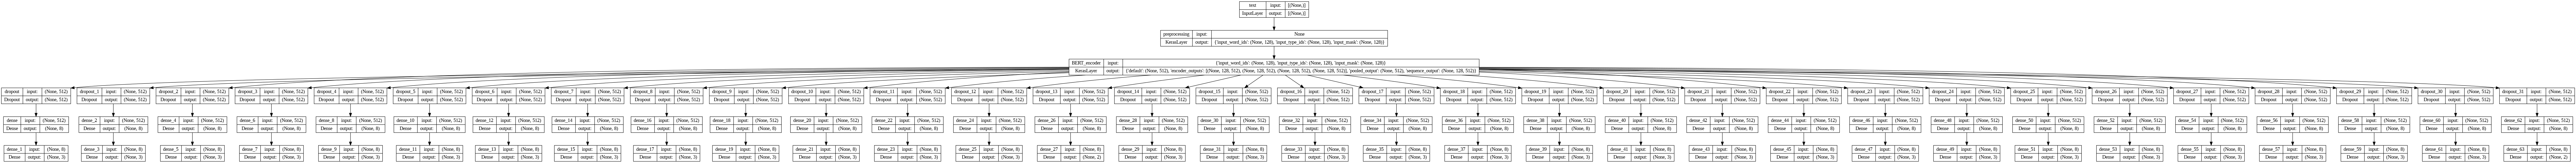

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history=model.fit(x, final,
                  epochs=50,
                  batch_size=32)

Epoch 1/50
 88/317 [=======>......................] - ETA: 8:09 - loss: 7.3132 - dense_129_loss: 0.6797 - dense_131_loss: 0.7345 - dense_133_loss: 0.4547 - dense_135_loss: 0.3759 - dense_137_loss: 0.3038 - dense_139_loss: 0.2154 - dense_141_loss: 0.3936 - dense_143_loss: 0.2530 - dense_145_loss: 0.3136 - dense_147_loss: 0.1941 - dense_149_loss: 0.2062 - dense_151_loss: 0.2537 - dense_153_loss: 0.0757 - dense_155_loss: 0.0944 - dense_157_loss: 0.1144 - dense_159_loss: 0.1460 - dense_161_loss: 0.1194 - dense_163_loss: 0.1239 - dense_165_loss: 0.0705 - dense_167_loss: 0.1794 - dense_169_loss: 0.5900 - dense_171_loss: 0.1253 - dense_173_loss: 0.0502 - dense_175_loss: 0.0715 - dense_177_loss: 0.0798 - dense_179_loss: 0.1380 - dense_181_loss: 0.1066 - dense_183_loss: 0.2669 - dense_185_loss: 0.2286 - dense_187_loss: 0.1216 - dense_189_loss: 0.1639 - dense_191_loss: 0.0690